# Image decompression and azimuthal integration on the GPU

This tutorial explains how it is possible to speed-up azimuthal integration by speeding-up the critical part: the data transfer to the GPU.

For this tutorial, very recent version of `silx` and `pyFAI` are needed, newer than fall 2022.

**Credits:**

* Thomas Vincent (ESRF) for the HDF5 direct chunk read and the Jupyter-slurm
* Jon Wright (ESRF) for the initial prototype of the bitshuffle-LZ4 decompression on the GPU
* Pierre Paleo (ESRF) for struggling with this kind of stuff with GPUs

**Nota:** a (fast) GPU is needed for this tutorial with OpenCL properly setup !

The example taken here is the same as the multithreading example: 4096 frames of Eiger_4M in one file to be decompressed and integrated.

In [1]:
%matplotlib inline

In [2]:
import sys, os, collections, struct, time
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"
import numpy, pyFAI
import h5py, hdf5plugin
from matplotlib.pyplot import subplots
import bitshuffle
import pyopencl.array as cla
import silx
from silx.opencl import ocl
from silx.opencl.codec.bitshuffle_lz4 import BitshuffleLz4
start_time = time.time()
ocl

OpenCL devices:
[0] NVIDIA CUDA: (0,0) NVIDIA GeForce GT 1030, (0,1) NVIDIA GeForce GTX 750 Ti
[1] AMD Accelerated Parallel Processing: (1,0) gfx900:xnack-
[2] Intel(R) OpenCL: (2,0) AMD EPYC 7262 8-Core Processor

In [3]:
#Here we select the OpenCL device
target = (1,0)
device = ocl.platforms[target[0]].devices[target[1]]
print("Working on device:", device)

Working on device: gfx900:xnack-


## Setup the enviroment:

This is a purely virtual experiment, we will use an Eiger 4M detector with data integrated over 1000 bins. Those parameters can be tuned.

Random data are generated, to keep this file fairly small, it is generated with small numbers which compress nicely. The speed of the drive where you will put the file is likely to have a huge impact !

In [4]:
det = pyFAI.detector_factory("eiger_4M")
shape = det.shape
dtype = numpy.dtype("uint32")
filename = "/tmp/big.h5"
nbins = 1000
cmp = hdf5plugin.Bitshuffle()
hdf5plugin.config

HDF5PluginBuildConfig(openmp=False, native=True, sse2=True, avx2=True, cpp11=True, filter_file_extension='.so', embedded_filters=('blosc', 'bshuf', 'bzip2', 'fcidecomp', 'lz4', 'zfp', 'zstd'))

In [5]:
mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
print(f"Number of frames the computer can host in memory: {mem_bytes/(numpy.prod(shape)*dtype.itemsize):.3f}")
if os.environ.get('SLURM_MEM_PER_NODE'):
    print(f"Number of frames the computer can host in memory with SLURM restrictions: {int(os.environ['SLURM_MEM_PER_NODE'])*(1<<20)/(numpy.prod(shape)*dtype.itemsize):.3f}")

Number of frames the computer can host in memory: 3754.675


In [6]:
#The computer being limited to 64G of RAM, the number of frames actually possible is 3800.
nbframes = 4096 # slightly larger than the maximum achievable ! Such a dataset should not host in memory.

In [7]:
#Prepare a frame with little count so that it compresses well
geo = {"detector": det, 
       "wavelength": 1e-10, 
       "rot3":0} #work around a bug https://github.com/silx-kit/pyFAI/pull/1749
ai = pyFAI.load(geo)
omega = ai.solidAngleArray()
q = numpy.arange(15)
img = ai.calcfrom1d(q, 100/(1+q*q))
frame = numpy.random.poisson(img).astype(dtype)

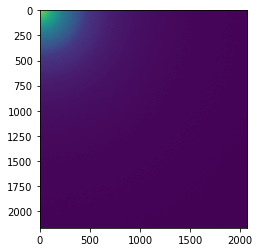

In [8]:
# display the image
fig,ax = subplots()
ax.imshow(frame)
pass

In [9]:
print("Performances of the different algorithms for azimuthal integration of Eiger 4M image on the CPU")
for algo in ("histogram", "csc", "csr"):
    print(f"Using algorithm {algo:10s}:", end=" ")
    %timeit ai.integrate1d(frame, nbins, method=("full", algo, "cython"))
print("Performances of the different algorithms for azimuthal integration of Eiger 4M image on the GPU: ", device)
print(f"Using algorithm {algo:10s}:", end=" ")
timing_integration = %timeit -o ai.integrate1d(frame, nbins, method=("full", algo, "opencl", target))

Performances of the different algorithms for azimuthal integration of Eiger 4M image on the CPU
Using algorithm histogram : 647 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using algorithm csc       : 47.2 ms ± 458 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using algorithm csr       : 64.3 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Performances of the different algorithms for azimuthal integration of Eiger 4M image on the GPU:  gfx900:xnack-
Using algorithm csr       : 5.4 ms ± 385 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/jerome/.venv/py39/lib/python3.9/site-packages/pyopencl/__init__.py:270: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'gfx900:xnack-' on 'AMD Accelerated Parallel Processing' at 0x2431b30> succeeded, but said:

1 warning generated.

  warn(text, CompilerWarning)


**Note:** The full pixel splitting is time consuming and handicaps the histogram algorithm while both sparse-matrix methods are much faster since they cache this calculation in the sparse matrix.

On the AMD-EPYC processor, with its large cache, the serial CSC algorithm is much faster than the CSR despite the later uses 8 cores !!!

In [10]:
# How is the time spend when integrating on GPU (with default parameters) ?
res0 = ai.integrate1d(frame, nbins, method=("full", "csr", "opencl", target))
engine = ai.engines[res0.method].engine
engine.reset_log()
engine.set_profiling(True)
omega_crc = engine.on_device["solidangle"]
%timeit engine.integrate_ng(frame, solidangle=omega, solidangle_checksum=omega_crc)
print("\n".join(engine.log_profile(stats=True)))
engine.set_profiling(False)
engine.reset_log()

5.35 ms ± 246 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

OpenCL kernel profiling statistics in milliseconds for: OCL_CSR_Integrator
                                       Kernel name (count):      min   median      max     mean      std
                               copy raw H->D image (  811):    1.286    1.309    1.369    1.310    0.010
                              convert u32_to_float (  811):    0.114    0.119    0.502    0.138    0.077
                                         memset_ng (  811):    0.005    0.006    0.020    0.006    0.002
                                      corrections4 (  811):    0.348    0.352    1.120    0.633    0.349
                                    csr_integrate4 (  811):    2.615    2.663    2.708    2.663    0.017
                                  copy D->H avgint (  811):    0.003    0.005    0.015    0.005    0.001
                                     copy D->H std (  811):    0.003    0.004    0.006    0.004    0.000
             

**Note:** A large part of the time is spent in the transfer from the host to the device.

### Let's benchmark azimuthal integration without this transfer:

Just transfer the image to the GPU ... 

In [11]:
frame_d = cla.to_device(engine.queue, frame)
engine.set_profiling(True)
tai_before = %timeit -o engine.integrate_ng(frame_d, solidangle=omega, solidangle_checksum=omega_crc)
print("\n".join(engine.log_profile(stats=True)))
engine.set_profiling(False)
engine.reset_log()

3.71 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

OpenCL kernel profiling statistics in milliseconds for: OCL_CSR_Integrator
                                       Kernel name (count):      min   median      max     mean      std
                               copy raw D->D image (  811):    0.111    0.113    0.480    0.114    0.013
                              convert u32_to_float (  811):    0.113    0.115    0.453    0.116    0.012
                                         memset_ng (  811):    0.004    0.005    0.008    0.005    0.000
                                      corrections4 (  811):    0.347    0.350    0.354    0.350    0.001
                                    csr_integrate4 (  811):    2.624    2.673    2.736    2.674    0.020
                                  copy D->H avgint (  811):    0.003    0.004    0.008    0.004    0.000
                                     copy D->H std (  811):    0.003    0.004    0.005    0.004    0.000
             

In [12]:
# Workgroup size ranges for the different kernels involved:
for k,v in engine.workgroup_size.items():
    print(k,v)

memset1 (64, 256)
csr_integrate4 (64, 256)
csr_sigma_clip4 (64, 256)
memset8 (64, 256)
csr_integrate_single (64, 256)
s8_to_float (64, 256)
memset4 (64, 256)
csr_integrate (64, 256)
csr_integrate4_single (1, 1)
u32_to_float (64, 256)
u16_to_float (64, 256)
corrections4 (64, 256)
s32_to_float (64, 256)
u8_to_float (64, 256)
s16_to_float (64, 256)
memset_out (64, 256)
memset_int (64, 256)
memset_ng (64, 256)
corrections (64, 256)
memset2 (64, 256)
corrections2 (64, 256)
corrections3 (64, 256)


In [13]:
# Profiling the engine with various workgroup sizes:
wg=32
wg_max = 256
res0 = ai.integrate1d(frame, nbins, method=("full", "csr", "opencl", target))
engine = ai.engines[res0.method].engine
omega_crc = engine.on_device["solidangle"]
engine.reset_log()
engine.set_profiling(True)

while wg<=wg_max:
    print(f"\nWorkgroup_size: {wg} ", end="")
    %timeit engine.integrate_ng(frame_d, solidangle=omega, solidangle_checksum=omega_crc, workgroup_size=wg)
    print("\n".join(engine.log_profile(stats=True)))
    print("*"*50)
    engine.reset_log()
    wg*=2

engine.set_profiling(False)


Workgroup_size: 32 3.74 ms ± 8.62 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

OpenCL kernel profiling statistics in milliseconds for: OCL_CSR_Integrator
                                       Kernel name (count):      min   median      max     mean      std
                               copy raw D->D image (  811):    0.111    0.113    0.497    0.114    0.014
                              convert u32_to_float (  811):    0.348    0.360    0.364    0.356    0.005
                                         memset_ng (  811):    0.004    0.004    0.009    0.004    0.000
                                      corrections4 (  811):    0.353    0.365    0.367    0.362    0.005
                                    csr_integrate4 (  811):    2.518    2.633    2.758    2.630    0.044
                                  copy D->H avgint (  811):    0.003    0.004    0.010    0.004    0.000
                                     copy D->H std (  811):    0.003    0.004    0.008    0.004  

**Note:** 

* A large fraction of the time is spent in the transfer from the CPU to the GPU.
* Different kernels see different minimum execution time depending on their structure. For this AMD Vega GPU one observes:

  - simple conversion kernel are best used with largest workgroup size (256)
  - CSR sparse matrix multiplication is best used with a very small workgroup size (32)
  - correction is best used with 128 threads per workgroup.

Those results also vary from device to device and between drivers !

In [14]:
#tune the different workgroup sizes:
engine.workgroup_size["csr_integrate4"] = (32, 32)
engine.workgroup_size["corrections4"] = (128, 128)
engine.workgroup_size["s32_to_float"] = (256, 256)
engine.workgroup_size["u8_to_float"] = (256, 256)
engine.workgroup_size["s16_to_float"] = (256, 256)
engine.workgroup_size["s8_to_float"] = (256, 256)
engine.workgroup_size["u32_to_float"] = (256, 256)
engine.workgroup_size["u16_to_float"] = (256, 256)
tai_after = %timeit -o engine.integrate_ng(frame_d, solidangle=omega, solidangle_checksum=omega_crc)
print(f"Workgroup size optimization allowed to gain: {(tai_before.average-tai_after.average)/tai_before.average*100:.1f}%")

3.46 ms ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Workgroup size optimization allowed to gain: 6.8%


## Preparation of some HDF5 file:

* with many frames in them, 
* compressed in Bitshuffle-LZ4,
* each chunk being one frame.

In [15]:
%%timeit -r1 -n1 -o -q
#Saving of a HDF5 file with many frames ...
with h5py.File(filename, "w") as h:
    ds = h.create_dataset("data", shape=(nbframes,)+shape, chunks=(1,)+shape, dtype=dtype, **cmp) 
    for i in range(nbframes):
        ds[i] = frame + i%500 #Each frame has a different value to prevent caching effects

<TimeitResult : 1min 5s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [16]:
timing_write = _
size=os.stat(filename).st_size
print(f"File size {size/(1024**3):.3f} GB with a compression ratio of {nbframes*numpy.prod(shape)*dtype.itemsize/size:.3f}x")
print(f"Write speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_write.best):.3f} MB/s of uncompressed data, or {nbframes/timing_write.best:.3f} fps.")

File size 9.241 GB with a compression ratio of 7.407x
Write speed: 1116.307 MB/s of uncompressed data, or 62.215 fps.


In [17]:
%%timeit -r1 -n1 -o -q
#Reading all frames and decompressing them
buffer = numpy.zeros(shape, dtype=dtype)
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(nbframes):
        ds.read_direct(buffer, numpy.s_[i,:,:], numpy.s_[:,:])

<TimeitResult : 43.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [18]:
timing_read1 = _
print(f"Read speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_read1.best):.3f} MB/s of uncompressed data, or {nbframes/timing_read1.best:.3f} fps.")

Read speed: 1680.001 MB/s of uncompressed data, or 93.631 fps.


In [19]:
# Time for decompressing one frame:
chunk = bitshuffle.compress_lz4(frame,0)
print(f"Compression ratio: {frame.nbytes/len(chunk):.3f}x")
timing_decompress = %timeit -o bitshuffle.decompress_lz4(chunk, frame.shape, frame.dtype, 0)
print(f"Decompression speed: {1/timing_decompress.best:.3f} fps")

Compression ratio: 9.097x
13.1 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Decompression speed: 77.905 fps


In [20]:
%%timeit -r1 -n1 -o -q
#Reading all frames without decompressing them
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(ds.id.get_num_chunks()):
        filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)

<TimeitResult : 1.93 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [21]:
timing_read2 = _
print(f"Read speed: {size/(1e6*timing_read2.best):.3f} MB/s of compressed data.")
print(f"HDF5 read speed (without decompression): {nbframes/timing_read2.best:.3f} fps.")

Read speed: 5136.479 MB/s of compressed data.
HDF5 read speed (without decompression): 2120.279 fps.


In [22]:
timimg_sum = timing_integration.best + timing_read2.best/nbframes+timing_decompress.best
print(f"The maximum throughput considering reading, decompression and integration is {1/timimg_sum:.3f} fps.")

The maximum throughput considering reading, decompression and integration is 54.595 fps.


**Summary:**

* Read speed: 2100 fps
* Read + decompress: 93 fps
* Read + decomperss + integrate: 55 fps.

## Decompression on the GPU

Decompression of the GPU has 3 main advantages:

* Transfer less data from the the host to the device since it is compressed
* Inflated data on the device remain on the device, thus 
* Most of the decompression algorithm is performed in parallel and exploits the GPU efficiently

There is one part of the decompression which remains serial, the part searching for the begining of each of the compressed blocks.

**Nota:** This feature requires silx 1.2 !

In [24]:
# Read one chunk
with h5py.File(filename, "r") as h:
    ds = h["data"]
    i=0
    filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)

In [25]:
gpu_decompressor = BitshuffleLz4(len(chunk), frame.size, dtype=frame.dtype, ctx=engine.ctx)

In [26]:
#Tune the decompressor for the fastest speed:
wg = 32
wg_max=256
gpu_decompressor.set_profiling(True)
while wg<=wg_max:
    print(f"Workgroup size {wg:3d} : ", end=" ")
    %timeit gpu_decompressor.decompress(chunk, wg=wg); gpu_decompressor.queue.finish()
    print("\n".join(gpu_decompressor.log_profile(stats=True)))
    gpu_decompressor.reset_log()
    wg*=2
    
gpu_decompressor.set_profiling(False)

Workgroup size  32 :  3.84 ms ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

OpenCL kernel profiling statistics in milliseconds for: BitshuffleLz4
                                       Kernel name (count):      min   median      max     mean      std
                                   copy raw H -> D (  811):    0.145    0.146    0.400    0.146    0.009
                                       LZ4 unblock (  811):    1.079    1.112    1.156    1.112    0.014
                                    LZ4 decompress (  811):    2.358    2.397    2.454    2.395    0.015
________________________________________________________________________________
                       Total OpenCL execution time        : 2963.110ms
Workgroup size  64 :  2.78 ms ± 4.26 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

OpenCL kernel profiling statistics in milliseconds for: BitshuffleLz4
                                       Kernel name (count):      min   median      max     mean   

In [27]:
#Set the workgroup size (called block in cuda) to the best value we found previoulsy
gpu_decompressor.block_size = 256 

## Assemble optimized OpenCL blocks and integrate all frames from a HDF5-file

In [28]:
#Build a pipeline with decompression and integration on the GPU:
%timeit engine.integrate_ng(gpu_decompressor(chunk), solidangle=omega, solidangle_checksum=omega_crc)

5.83 ms ± 35.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
result = numpy.empty((nbframes, nbins), dtype=numpy.float32)

In [30]:
%%timeit -r1 -n1 -o -q
# Process a complete stack:
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(ds.id.get_num_chunks()):
        filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)
        result[i] = engine.integrate_ng(gpu_decompressor(chunk), solidangle=omega, solidangle_checksum=omega_crc).intensity

<TimeitResult : 26.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [31]:
timing_process_gpu = _
print(f"Processing speed when decompression occures on GPU: {nbframes/timing_process_gpu.best:.3f} fps which represents at speed-up of {timimg_sum*nbframes/timing_process_gpu.best:.3f}x.")

Processing speed when decompression occures on GPU: 156.382 fps which represents at speed-up of 2.864x.


## Display some results
Since the input data were all synthetic and similar, no great science is expected from this... but one can ensure each frame differs slightly from the neighbors with a pattern of 500 frames. 

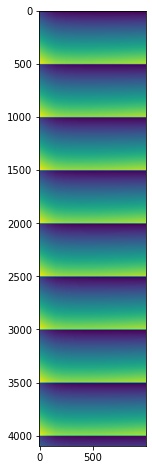

In [32]:
fig,ax = subplots(figsize=(8,8))
ax.imshow(result)

## Conclusion

Reading Bitshuffle-LZ4 data can be off-loaded to the GPU, this is especially appealing when downstream processing requires also GPU-computing llike azimuthal integration. 

The procedure is simpler than the multi-threading approach: no queue, no threads, ... but requires a GPU.

The performances obtained on a (not so recent Tesla V100) is similar to a much more recent 2x32-cores computer: ~500 fps

Those performances can be further parallelized using multiprocessing.

In [33]:
print(f"Total processing time: {time.time()-start_time:.3f} s")

Total processing time: 199.396 s
